# Lesson 6: Essay Writer

In [ ]:
!pip install langchain langgraph langchain_openai tavily-python

In [ ]:
import os
from google.colab import userdata

# Set up your OpenAI API key
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Set up your Tavily API key. Replace 'YOUR_TAVILY_API_KEY' with your actual key.
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [ ]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [ ]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [ ]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

In [ ]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [ ]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [ ]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [ ]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [ ]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [ ]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [ ]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [ ]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }


In [ ]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [ ]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [ ]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [ ]:
builder = StateGraph(AgentState)

In [ ]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [ ]:
builder.set_entry_point("planner")

In [ ]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)


In [ ]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [ ]:
graph = builder.compile(checkpointer=memory)

In [ ]:
!apt-get install graphviz libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

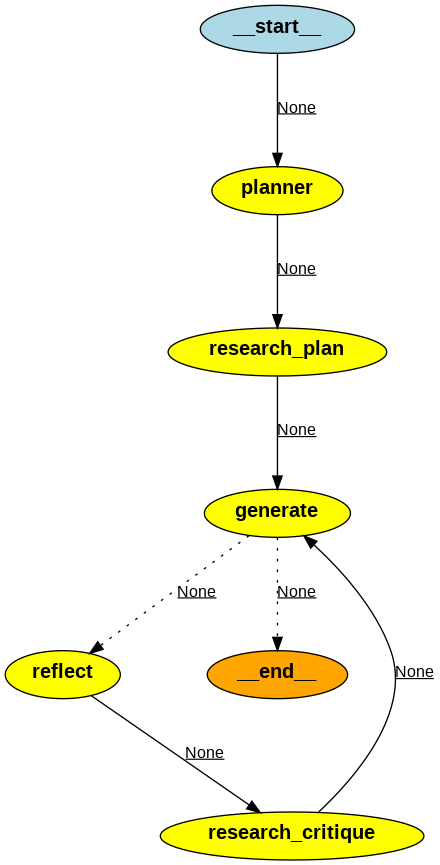

In [ ]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [ ]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Interoperability\n    E. Performance\n\nV. Conclusion\n    A. Recap of main points\n    B. Implications of the differences between Langchain and Langsmith\n    C. Future outlook for both technologies\n\nNotes:\n- Ensure to provide clear definitions and explanations of both Langchain and Langsmith.\n- Include specific examples of use cases and applications for each technology

## Essay Writer Interface